### Model overfitting
Размер тренировочного набора: 1000 (маленький размер выбран для демонстрации переобучения)

Размер валидационного набора: 10000

Модели состоят из 9 полносвязных слоев с 32 нейронами в каждом, в качестве функции активации используется гиперболический тангенс

В некоторые модели так же добавлены батч-нормализация и дропаут

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs
import numpy as np

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 50
neuNum = 32

In [3]:
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, train=1000)

In [4]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0., neuNum=128):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, neuNum)
        self.fc2 = nn.Linear(neuNum, neuNum)
        self.fc3 = nn.Linear(neuNum, neuNum)
        self.fc4 = nn.Linear(neuNum, neuNum)
        self.fc5 = nn.Linear(neuNum, neuNum)
        self.fc6 = nn.Linear(neuNum, neuNum)
        self.fc7 = nn.Linear(neuNum, neuNum)
        self.fc8 = nn.Linear(neuNum, neuNum)        
        self.fc9 = nn.Linear(neuNum, 10)
        if batchnorm:
            self.bn1 = nn.BatchNorm1d(neuNum)
            self.bn2 = nn.BatchNorm1d(neuNum)
            self.bn3 = nn.BatchNorm1d(neuNum)
            self.bn4 = nn.BatchNorm1d(neuNum)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn1(x)
        x = F.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc3(x))
        
        if self.batchnorm:
            x = self.bn2(x)
        x = F.tanh(self.fc4(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc5(x))   
        
        if self.batchnorm:
            x = self.bn3(x)
        x = F.tanh(self.fc6(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.tanh(self.fc7(x))         

        if self.batchnorm:
            x = self.bn4(x)
        x = F.tanh(self.fc8(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc9(x)              
        
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def test(models, loader, log=None, Name='Test'):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data.to(device))
                test_loss[k] += m.loss(output, target.to(device), reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.to(device).data.view_as(pred)).cpu().sum()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = Name+' set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data.to(device))
            loss = model.loss(output, target.to(device))
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    test(models, train_loader, log, 'Train')

In [7]:
models = {'default': Net(False, False, neuNum=neuNum).to(device), 'bn': Net(True, False, neuNum=neuNum).to(device), 'drop': Net(False, True, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
# models = {'default': Net(False, False, neuNum=neuNum).to(device), 'both': Net(True, True, neuNum=neuNum).to(device)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
for epoch in range(1, 201):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

In [9]:
import matplotlib.pyplot as plt

Из графика ошибок видно, что ошибка всех моделей на тренировочном наборе с течением эпох стремится к 0.

Начиная с 25 эпохи ошибка моделей на тестовом наборе начинает отклонятся от ошибки соотвествующих моделей на тренировочном наборе.

На эпохах 100-125 ошибки на тестовом наборе практически перестают изменятся, у моделей 'default' и 'drop' ошибки начинают увеличиваться.

Судя по графикам, у моделей с батч-нормализацией ошибка уменьшается быстрее (обучаются быстрее). Если взять уровень ошибки 0.1015 (train loss у 'default' модели на последней эпохе) и посмотреть соответствующие ошибки на тестовом наборе у различных моделей, то окажется, что ошибки сильно отличаются. Получается, что при одинаковой ошибке на тренировочном наборе обобщающая способность моделей отличается. Лучше всего с обобщением справились модели с батч-нормализацией. Модель с дропаутом так же лучше обобщает, чем модель без дропаута и батч-нормализации.

не совсем корректно делать выводы на основе одного прогона, но некоторые предварительные гипотезы сделать можно :)

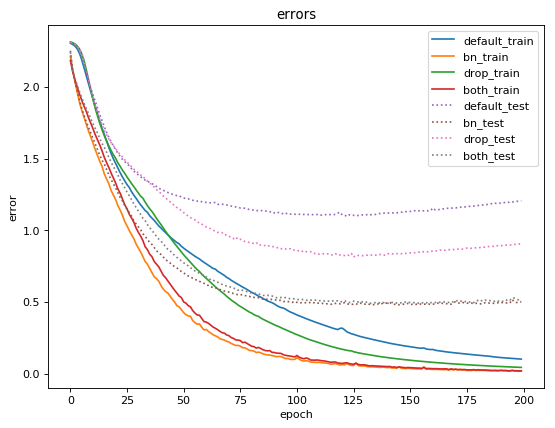

In [10]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'loss')

Из графика точности так же видно, что модели с батч-нормализацией учат тренировочный набор быстрее моделей без нее.

Начиная с 100 эпохи точность на тренировочном наборе практически равна 100%. Но на тестовом наборе точность намного хуже. 

Лучше всего себя показали модели с батч-нормализацией - точность 85-86% (начиная с 50 эпохи). Хуже всего модель 'default' - точность 73%. У модели с дропаутом точность 79%.

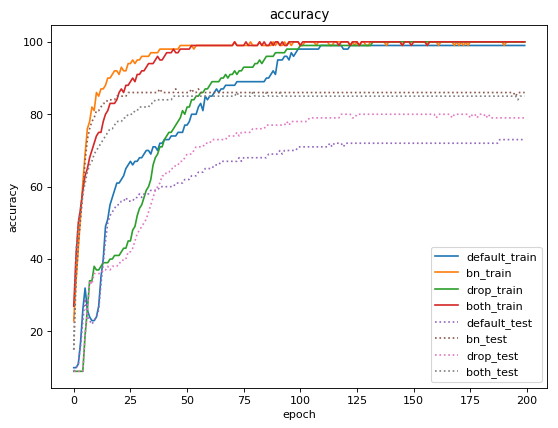

In [11]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plot_graphs(train_log, test_log, 'accuracy')